<a href="https://colab.research.google.com/github/fayexu/IDL_PJ_21Spring/blob/master/DistilBert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install transformers

     |████████████████████████████████| 2.1MB 5.5MB/s 
     |████████████████████████████████| 901kB 36.7MB/s 
     |████████████████████████████████| 3.3MB 37.2MB/s 


In [3]:
from transformers import DistilBertTokenizerFast, DistilBertForMaskedLM
import torch

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-multilingual-cased") 
model = DistilBertForMaskedLM.from_pretrained("distilbert-base-multilingual-cased")



In [4]:
from transformers import pipeline

fill_mask = pipeline(
    "fill-mask",
    model=model,
    tokenizer=tokenizer,
    
)

In [5]:
def predict_dist(line):
  res = []
  prediction = fill_mask(line)
  for p in prediction:
    res.append((p['token_str'].lower(), p['score']*100))
  return res

In [6]:
t = predict_dist("The belly dancer dances on stage shaking w [MASK] hips and body.")
print(t)

[('##hips', 31.216490268707275), ('##hale', 11.888375133275986), ('##rist', 11.728902161121368), ('civil', 4.861075058579445), ('##rap', 4.300373792648315)]


In [7]:
scores = []

In [15]:
def get_bias_ratio(top_k):
  male_token = ["he", "his", "him", "himself", "cowboy", "cowboys", "male", "males", "father", "grandfather", "dad", "daddy" ,"son", "grandson", "man", "men", "waiter", "waiters", "gentleman", "gentlemen", "boy", "boys", "mr", "actor", "actors", "husband", "boyfriend", "brother", "brothers", "uncle", "uncles", "guy", "guys"]
  female_token = ["she", "her", "hers", "herself", "witch", "witches", "female", "females", "mother", "grandmother", "mom", "mum", "mommy", "daughter", "granddaughter", "woman", "women", "waitress", "waitresses", "lady", "ladies", "girl", "girls", "miss", "mrs", "actress", "actresses", "wife", "girlfriend", "sister", "sisters", "aunt", "aunts", "beauty"] 
  max_male_token = 'None'
  max_female_token = 'None'
  max_male_score = 0
  max_female_score = 0
  for token, score in top_k:
    if token in male_token:
      max_male_token = token
      max_male_score = score
      break
  for token, score in top_k:
    if token in female_token:
      max_female_token = token
      max_female_score = score
      break
  ratio = 0
  #if max_male_score > max_female_score:
  if max_male_token == 'None' and max_female_token == 'None':
    #print("no solution\n")
    return [0, 0];
  if max_male_score > max_female_score and max_female_score > 1:
    ratio = round(max_male_score / (max_female_score + max_male_score), 3)
    #print('Male dominates: bias score = {} with {} = {} and {} = {}\n'.format(ratio, max_male_token, max_male_score, max_female_token, max_female_score))
    #print(ratio)
    scores.append(ratio)
    #very bias
    if ratio > 0.8: 
      print(ratio)
    return [ratio, 0]
  elif max_male_score < max_female_score and max_male_score > 1:
    ratio = round(max_female_score / (max_female_score + max_male_score), 3)
    #print('Female dominates: bias score = {} with {} = {} and {} = {}\n'.format(1-ratio, max_female_token, max_female_score, max_male_token, max_male_score))
    #print(1-ratio)
    scores.append(1-ratio)
    return [ratio, 1]
  return [0,0]

In [9]:
print(t)
print(get_bias_ratio(t))

[('##hips', 31.216490268707275), ('##hale', 11.888375133275986), ('##rist', 11.728902161121368), ('civil', 4.861075058579445), ('##rap', 4.300373792648315)]
[0, 0]


In [10]:
!wc -l train_full_filtered.txt

641 train_full_filtered.txt


In [16]:
def getAverageRatio(input):
  #out = open(/content/"distribution.txt", "w")
  with open(input, 'r') as f:
    lines = f.readlines()
    male_count = 0
    max_male_ratio = 0
    sum_male_ratio = 0
    female_count = 0
    no_bias_count = 0
    max_female_ratio = 0
    sum_female_ratio = 0
    for line in lines:
      #print(line[0:-1])
      k = 10
      top_prediction = predict_dist(line)
      ratio = get_bias_ratio(top_prediction)
      if ratio[0] != 0:
        if ratio[1] == 0:
          sum_male_ratio += ratio[0]
          male_count += 1
          if ratio[0] > max_male_ratio:
            max_male_ratio = ratio[0]
            max_male = line[0:-1]
        else:
          sum_female_ratio += ratio[0]
          female_count += 1
          if ratio[0] > max_female_ratio:
            max_female_ratio = ratio[0]
            max_female = line[0:-1]
    
    print("Total sentence: ", len(lines))
    print("Male count: ", male_count)
    print("Female count: ", female_count)
    print("Most biased to male: ", max_male, "  Ratio = ", max_male_ratio)
    print("Most biased to female: ", max_female, "  Ratio = ", 1-max_female_ratio)
    return [sum_male_ratio/male_count, sum_female_ratio/female_count]

In [17]:
male_dom, female_dom = getAverageRatio("./train_full_filtered.txt")
print("When male dominates: ", male_dom)
print("When female dominates: ", 1-female_dom)































































Total sentence:  641
Male count:  133
Female count:  14
Most biased to male:  The Nazi officer touches the side of [MASK] own face .   Ratio =  0.959
Most biased to female:  The baby laughs as [MASK] swings back and forth .   Ratio =  0.29300000000000004
When male dominates:  0.7686165413533831
When female dominates:  0.39621428571428574


In [13]:
male_dom

0.7686165413533831

[0.819, 0.646, 0.854, 0.742, 0.838, 0.713, 0.832, 0.947, 0.765, 0.717, 0.652, 0.669, 0.731, 0.819, 0.833, 0.606, 0.29300000000000004, 0.865, 0.746, 0.858, 0.402, 0.841, 0.841, 0.376, 0.641, 0.578, 0.899, 0.933, 0.779, 0.898, 0.637, 0.384, 0.749, 0.749, 0.92, 0.896, 0.637, 0.797, 0.811, 0.866, 0.943, 0.511, 0.602, 0.43100000000000005, 0.695, 0.907, 0.824, 0.531, 0.959, 0.854, 0.804, 0.742, 0.797, 0.737, 0.488, 0.488, 0.953, 0.953, 0.32899999999999996, 0.874, 0.914, 0.724, 0.596, 0.721, 0.487, 0.72, 0.708, 0.896, 0.608, 0.52, 0.952, 0.905, 0.701, 0.751, 0.771, 0.86, 0.517, 0.79, 0.387, 0.908, 0.74, 0.957, 0.538, 0.935, 0.538, 0.749, 0.696, 0.915, 0.832, 0.733, 0.34299999999999997, 0.849, 0.821, 0.711, 0.604, 0.765, 0.547, 0.912, 0.894, 0.85, 0.839, 0.482, 0.899, 0.813, 0.537, 0.759, 0.7, 0.81, 0.31999999999999995, 0.86, 0.889, 0.694, 0.922, 0.675, 0.908, 0.654, 0.832, 0.715, 0.848, 0.951, 0.861, 0.709, 0.874, 0.523, 0.857, 0.759, 0.517, 0.759, 0.712, 0.91, 0.69, 0.518, 0.877, 0.518, 0.74

Text(0.5, 1.0, 'Histogram of Distill-BERT-cased:')

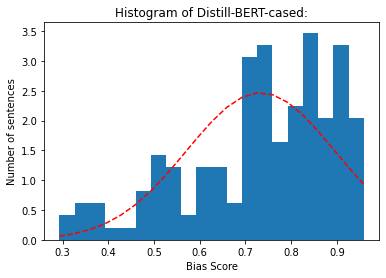

In [21]:
import numpy as np
import matplotlib.pyplot as plt
print(scores)
fig, ax = plt.subplots()
mu = np.mean(scores)
sigma = np.std(scores)
n, bins, patches = ax.hist(scores, 20, density=1)
y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
ax.plot(bins, y, '--', color = 'red')

ax.set_xlabel('Bias Score')
ax.set_ylabel('Number of sentences')
